<a href="https://colab.research.google.com/github/OscarUngsgard/Python-Financial-Engineering/blob/master/PortfolioOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Default title text
Imports = "" #@param {type:"string"}
#Imports
from datetime import datetime
from datetime import timedelta  
#import datetime
from dateutil.relativedelta import relativedelta
from collections import defaultdict
import os
import sys, os
import io
import math

import numpy as np
from numpy import linspace

import random
from random import choices

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data as wb
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
register_matplotlib_converters()


from pylab import plot,show,hist,figure,title

!pip install yfinance
import yfinance as yf
!pip install yahoo_fin
from yahoo_fin import options
yf.pdr_override()

from scipy import stats
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import basinhopping

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [0]:
#Functions to read in stock data
def returns(YahooTickers, starttime = datetime.today()-relativedelta(months=+12)):   #format tickers = ['AXFO.ST','HM-B.ST','PCELL.ST','SOLT.ST']
    mydata = pd.DataFrame()
    for t in YahooTickers:
        mydata[t] = yf.Ticker(t).history(start=starttime, end = datetime.today())["Close"]
        returns = np.log(mydata/mydata.shift(1))
    #print("Number of null values filled: ")
    #print(np.isnan(returns).sum())
    returns.fillna(method='ffill', inplace=True) #NA = last value
    returns = returns.apply(lambda x: x.fillna(x.mean()),axis=1) #NA = average of rows if never available.
    return returns[1:]

In [0]:
######Numerical Calculation Functions#########

##Covariance Matrix Calculations
#Helper functions to calculate Leodit Wolf covriance matrix with constant correlation shrinkage taret (See article: http://www.ledoit.net/honey.pdf)
def cov_Matrix(returns, horizon = 252):
    return returns.cov() * horizon

def constant_corr_Matrix(returns):
  horizon = 1
  corrmat = returns.corr()
  N = len(corrmat)
  meancorr = 0
  for i in range(N-1):
    for j in range(i+1,N):
      meancorr += corrmat.iloc[i,j]
  meancorr *= (2/(N*(N-1)))
  const_corr_mat = cov_Matrix(returns,horizon) / corrmat
  for i in range(N-1):
    for j in range(i+1,N):
      const_corr_mat.iloc[i,j] *= meancorr
      const_corr_mat.iloc[j,i] *= meancorr
  return const_corr_mat
def Shrinkage_Intensity(returns):
  horizon = 1
  ##corr_mean
  corrmat = returns.corr()
  N = len(corrmat)
  meancorr = 0
  for i in range(N-1):
    for j in range(i+1,N):
      meancorr += corrmat.iloc[i,j]
  meancorr *= (2/(N*(N-1)))
  ##pi
  covmat = cov_Matrix(returns,horizon)
  T = len(returns)
  pi = 0
  pidiag = 0
  y = lambda i : (returns[returns.columns[i]])
  for i in range(N):
    for j in range(N): 
      thisPi=0
      for t in range(T):
        thisPi +=  (( (y(i)[t]-y(i).mean()) * (y(j)[t]-y(j).mean()) - covmat.iloc[i,j] )**2 )* (1/T)
      pi += thisPi 
      if i==j:
       pidiag += thisPi
  ##rho
  theta = lambda i,j : (1/T) * sum( ((y(i)-y(i).mean())**2 - covmat.iloc[i,i]) * ((y(i)-y(i).mean())*(y(j)-y(j).mean()) - covmat.iloc[i,j]) )
  rho = pidiag
  for i in range(N):
    for j in range(N):
        if j != i:
          rho += (meancorr/2) * ( np.sqrt(covmat.iloc[j,j]/covmat.iloc[i,i]) * theta(i,j)  +  np.sqrt(covmat.iloc[i,i]/covmat.iloc[j,j]) * theta(j,i) ) 
  ##gamma
  const_corr_mat = constant_corr_Matrix(returns)
  gamma = 0
  for i in range(N):
    for j in range(N):
      gamma += (const_corr_mat.iloc[i,j]-covmat.iloc[i,j])**2
  ## k
  k = (pi-rho)/gamma
  ##Shrinkage intensity
  delta = max( 0 , min( (k/T) , 1 ) )
  return delta

#########Leodit Wolf covriance matrix with constant correlation shrinkage taret########
def cov_Matrix_Shrinked(returns,horizon = 252):
  sample_covmat = cov_Matrix(returns,1)
  shrinkage_target = constant_corr_Matrix(returns)
  shrinkage_intensity = Shrinkage_Intensity(returns)
  covmat_shrinked = shrinkage_intensity*shrinkage_target+(1-shrinkage_intensity)*sample_covmat
  covmat_shrinked *= horizon
  return covmat_shrinked

##Portfolio vol
def portfolio_vol_shrink(returns,weights,horizon=252):
  if abs(sum(weights)-1)>0.01:
      print("Weights must sum to 1.")
      return
  weights = np.array(weights)
  return (np.dot(weights.T, np.dot(cov_Matrix_Shrinked(returns,horizon),weights))) ** 0.5

In [0]:
###Miminimum Variance portfolio Helper function
def minimum_variance_portfolio_weights_analytic(thisTickers, V0=1): #With shrinking
  myreturns = returns(thisTickers)
  covMat = cov_Matrix_Shrinked(myreturns)
  covMatinv = np.linalg.inv(covMat)
  numerator = covMatinv.dot(np.ones((myreturns).shape[1]))
  denominator = np.ones((myreturns).shape[1]).dot(numerator)
  w = np.round((numerator/denominator),3)
  for x in range(len(w)):
    if w[x]<0:
      optimal_rel_weights_dict = { myreturns.columns[i] : np.round(w[i],3) for i in range(len(w)) }
      print("rejected portfolio weights: {})".format(optimal_rel_weights_dict))
      thisTickers.pop(x)
      w, *args = minimum_variance_portfolio_weights_analytic(thisTickers)
      break
  return_weights = np.round(w * V0,3)
  return (return_weights,thisTickers)
#### Miminum Variance Portfolio Calling function
def minimum_variance_portfolio_weights_analytic_dict(tickers, V0=1):
  thisTickers = tickers[:] #thisTickers will be modified
  optimal_weights, optimal_tickers = minimum_variance_portfolio_weights_analytic(thisTickers,V0=1)
  myreturns = returns(optimal_tickers)
  minimum_vol_an = portfolio_vol_shrink(myreturns, optimal_weights, 252)
  print("The minimum variance portfolio has {} volatility".format(np.round(minimum_vol_an,5)))
  optimal_abs_weights_dict = { myreturns.columns[i] : np.round(V0 * optimal_weights[i],3) for i in range(len(optimal_weights)) }
  optimal_rel_weights_dict = { myreturns.columns[i] : np.round(optimal_weights[i],3) for i in range(len(optimal_weights)) }
  print("Portfolio rel weights: {}".format(optimal_rel_weights_dict))
  print("Portfolio abs weights: {}".format(optimal_abs_weights_dict))
  return #optimal_abs_weights_dict

In [0]:
tickers = ['SF.ST' , 'STORY-B.ST','HNSA.ST','SINCH.ST','BETS-B.ST','LUN.TO','DOM.ST','PDX.ST'] 
minimum_variance_portfolio_weights_analytic_dict(tickers, 50000)

rejected portfolio weights: {'SF.ST': 0.155, 'STORY-B.ST': 0.154, 'HNSA.ST': -0.026, 'SINCH.ST': 0.083, 'BETS-B.ST': 0.108, 'LUN.TO': 0.068, 'DOM.ST': 0.12, 'PDX.ST': 0.338})
The minimum variance portfolio has 0.29416 volatility
Portfolio rel weights: {'SF.ST': 0.151, 'STORY-B.ST': 0.15, 'SINCH.ST': 0.076, 'BETS-B.ST': 0.102, 'LUN.TO': 0.06, 'DOM.ST': 0.115, 'PDX.ST': 0.346}
Portfolio abs weights: {'SF.ST': 7550.0, 'STORY-B.ST': 7500.0, 'SINCH.ST': 3800.0, 'BETS-B.ST': 5100.0, 'LUN.TO': 3000.0, 'DOM.ST': 5750.0, 'PDX.ST': 17300.0}


In [0]:
###Helper functions for plotting out the efficient frontier
def portfolio_vol(returns,weights,horizon=252):
    if abs(sum(weights)-1)>0.01:
        print("Weights must sum to 1.")
        return
    weights = np.array(weights)
    return (np.dot(weights.T, np.dot(cov_Matrix(returns,horizon),weights))) ** 0.5
def stock_exp_returns(returns, horizon):
    return returns.mean()*horizon
def portolio_exp_returns(returns, weights,horizon):
    if abs(sum(weights)-1)>0.01:
        print("Weights must sum to 1.")
        return
    weights = np.array(weights)
    return np.dot(weights.T, stock_exp_returns(returns,horizon))
def neg_sharpe(weights,returns):
    return get_ret_vol_sr(returns,weights)[2] * (-1)
def minimize_vol(weights,returns):
    return get_ret_vol_sr(returns,weights)[1]
def check_sum(weights):
    return np.sum(weights)-1
def get_ret_vol_sr(returns,weights):
    vol = portfolio_vol(returns,weights, 252)
    ret = portolio_exp_returns(returns, weights, 252)
    SR = ret/vol
    return np.array([ret,vol,SR])

In [0]:
####Plot out the entire efficient frontier with or without shortselling allowed. Expected returns calculated as average from historical values, in practice more refined estimations should be used.
def efficient_frontier_minimize(tickers, stepsize=0.01, shortselling = False):
    myreturns = returns(tickers)
    cons = ({'type':'eq','fun':check_sum})
    if not shortselling:
      bounds = tuple(zip(np.zeros(len(tickers)),np.ones(len(tickers))))     
    else:
      bounds = None
    init_guess = np.ones(len(tickers))*(1/len(tickers))
    #efficient frontier
    maxPossibleReturns = 3
    frontier_returns = np.linspace(0,maxPossibleReturns,round(maxPossibleReturns/stepsize))
    frontier_vol = []
    frontier_weights = []
    for possible_return in frontier_returns:
        cons2 = ({'type':'eq','fun':check_sum}, {'type':'eq','fun':lambda w: get_ret_vol_sr(myreturns,w)[0]-possible_return})
        opt_results2 = minimize(minimize_vol, init_guess,args=myreturns,method = 'SLSQP',bounds=bounds,constraints=cons2)
        if frontier_vol[-1:] and math.isclose(opt_results2.fun,frontier_vol[-1]): ##Max possible return/volatility pair found. Needed for no shortselling
          frontier_returns = np.resize(frontier_returns,len(frontier_vol))
          break 
        frontier_vol.append(opt_results2.fun)
        frontier_weights.append(opt_results2.x)
    
    tang_port_index = np.argmax(frontier_returns/frontier_vol)
    optimal_portfolio_weights = frontier_weights[tang_port_index].round(3)
    optimal_portfolio_weights_dict = {tickers[i] : optimal_portfolio_weights[i] for i in range(len(tickers))}
    print("Tangency portfolio weights:")
    print(optimal_portfolio_weights_dict)
    print("Expected return = {}".format(get_ret_vol_sr(myreturns,optimal_portfolio_weights)[0]))
    print("Volatility = {}".format(get_ret_vol_sr(myreturns,optimal_portfolio_weights)[1]))
    print("Sharpe Ratio = {}".format(get_ret_vol_sr(myreturns,optimal_portfolio_weights)[2]))

    min_var_index = np.argmin(frontier_vol)
    min_variance_portfolio_weights = frontier_weights[min_var_index].round(3)
    min_variance_portfolio_weights_dict = {tickers[i] : min_variance_portfolio_weights[i] for i in range(len(tickers))}
    print("min_variance weights:")
    print(min_variance_portfolio_weights_dict)
    print("Expected return = {}".format(get_ret_vol_sr(myreturns,min_variance_portfolio_weights)[0]))
    print("Volatility = {}".format(get_ret_vol_sr(myreturns,min_variance_portfolio_weights)[1]))
    print("Sharpe Ratio = {}".format(get_ret_vol_sr(myreturns,min_variance_portfolio_weights)[2]))

    plt.figure(figsize=(16,4));
    plt.scatter(frontier_vol,frontier_returns)
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier') 
    plt.plot(get_ret_vol_sr(myreturns,optimal_portfolio_weights)[1],get_ret_vol_sr(myreturns,optimal_portfolio_weights)[0], marker='o', markersize=5, color="red")
    plt.annotate("Tangency Portfolio",xy=(get_ret_vol_sr(myreturns,optimal_portfolio_weights)[1],get_ret_vol_sr(myreturns,optimal_portfolio_weights)[0])) 
    plt.plot(frontier_vol[min_var_index],frontier_returns[min_var_index], marker='o', markersize=5, color="red")
    plt.annotate("Min var Portfolio",xy=(frontier_vol[min_var_index],frontier_returns[min_var_index]))
    
    return #optimal_portfolio_weights_dict, min_variance_portfolio_weights_dict

With Shortselling
Tangency portfolio weights:
{'SF.ST': 1.321, 'STORY-B.ST': 0.548, 'HNSA.ST': -0.331, 'BETS-B.ST': -0.093, 'LUN.TO': -0.19, 'DOM.ST': -0.57, 'PDX.ST': 0.484, 'AXFO.ST': -0.167}
Expected return = 2.1871534161829187
Volatility = 0.7356694879030585
Sharpe Ratio = 2.973010913388767
min_variance weights:
{'SF.ST': 0.037, 'STORY-B.ST': 0.074, 'HNSA.ST': -0.005, 'BETS-B.ST': 0.077, 'LUN.TO': 0.012, 'DOM.ST': 0.109, 'PDX.ST': 0.14, 'AXFO.ST': 0.558}
Expected return = 0.20114366635575592
Volatility = 0.22590226152897405
Sharpe Ratio = 0.8904012956504085

No shortselling allowed
Tangency portfolio weights:
{'SF.ST': 0.64, 'STORY-B.ST': 0.196, 'HNSA.ST': 0.0, 'BETS-B.ST': 0.0, 'LUN.TO': 0.0, 'DOM.ST': 0.0, 'PDX.ST': 0.164, 'AXFO.ST': 0.0}
Expected return = 0.882938069493358
Volatility = 0.3718262835972063
Sharpe Ratio = 2.374598323043325
min_variance weights:
{'SF.ST': 0.039, 'STORY-B.ST': 0.074, 'HNSA.ST': 0.0, 'BETS-B.ST': 0.076, 'LUN.TO': 0.011, 'DOM.ST': 0.107, 'PDX.ST': 0.13

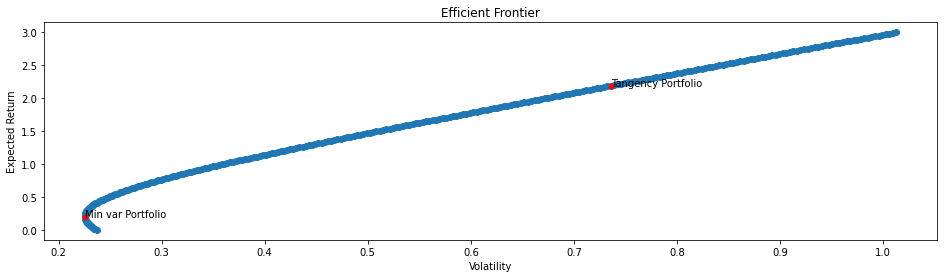

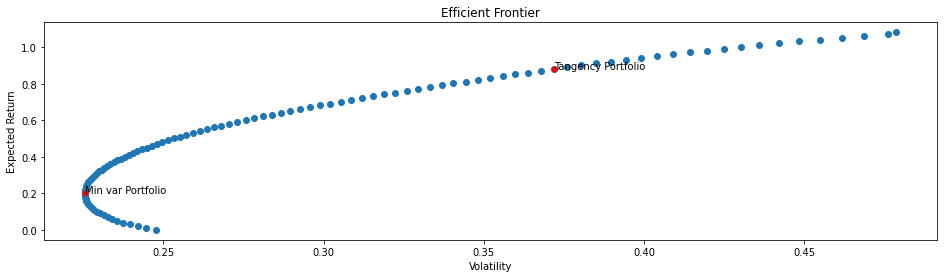

In [0]:
tickers = ['SF.ST' , 'STORY-B.ST','HNSA.ST','BETS-B.ST','LUN.TO','DOM.ST','PDX.ST','AXFO.ST']
print("With Shortselling")
efficient_frontier_minimize(tickers, shortselling = True)
print()
print("No shortselling allowed")
efficient_frontier_minimize(tickers, shortselling = False)